In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from node2vec import Node2Vec

In [33]:
# Load Karate Club Graph
graph = nx.karate_club_graph()
nodes = list(graph.nodes())

In [34]:
# Parameters
num_walks = 10  
walk_length = 10  
embedding_dim = 128  
num_epochs = 50
learning_rate = 0.
num_negative_samples = 5

In [15]:
# Generate random walks
def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    for _ in range(num_walks):
        for node in graph.nodes():
            walk = [node]
            for _ in range(walk_length - 1):
                neighbors = list(graph.neighbors(walk[-1]))
                if neighbors:
                    walk.append(random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

In [20]:
# Convert walks to training pairs
walks = generate_random_walks(graph, num_walks, walk_length)

positive_pairs = []
for walk in walks:
    for i, node in enumerate(walk):
        # 5 node window
        for j in range(max(0, i - 2), min(len(walk), i + 3)):
            if i != j:
                positive_pairs.append((node, walk[j]))
print(len(positive_pairs))

11560


In [35]:
# Negative sampling
all_nodes = set(graph.nodes())
negative_pairs = []
for node1, node2 in positive_pairs:
    for _ in range(num_negative_samples):
        neg_sample = random.choice(nodes)
        while neg_sample == node1 or neg_sample in graph.neighbors(node1):
            neg_sample = random.choice(nodes)
        negative_pairs.append((node1, neg_sample))

In [36]:
# Prepare training data
train_data = positive_pairs + negative_pairs
train_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

# Convert to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

In [38]:
# Define Skip-gram Neural Network with Negative Sampling
class SkipGramNN(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(SkipGramNN, self).__init__()
        self.input_embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.output_embeddings = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_pairs):
        node1 = self.input_embeddings(node_pairs[:, 0])
        node2 = self.output_embeddings(node_pairs[:, 1])
        return (node1 * node2).sum(dim=1)

In [39]:
# Model Initialization
model = SkipGramNN(len(nodes), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss()

In [40]:
# Training Loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = loss_function(outputs, train_labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 4.4435
Epoch 10, Loss: 4.4435
Epoch 20, Loss: 4.4435
Epoch 30, Loss: 4.4435
Epoch 40, Loss: 4.4435


In [47]:
# Extract learned embeddings
embeddings = model.output_embeddings.weight.detach().numpy()

In [48]:
# t-SNE Visualization
def plot_embeddings(embeddings, graph):
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(graph.nodes()):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=label)
    plt.show()

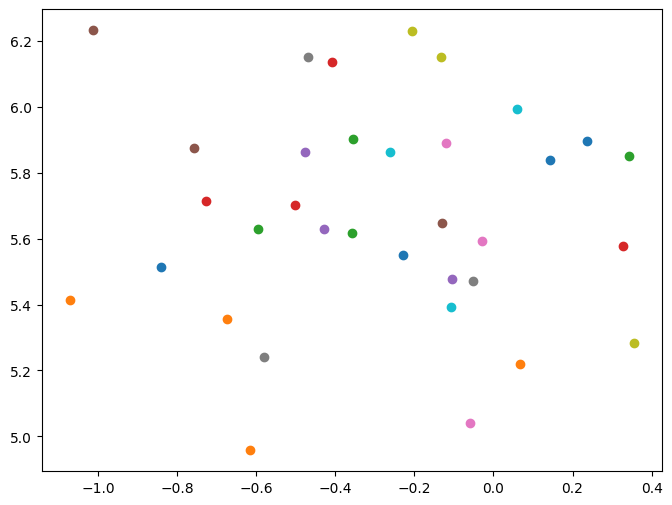

In [49]:
plot_embeddings(embeddings, graph)

Training DeepWalk...


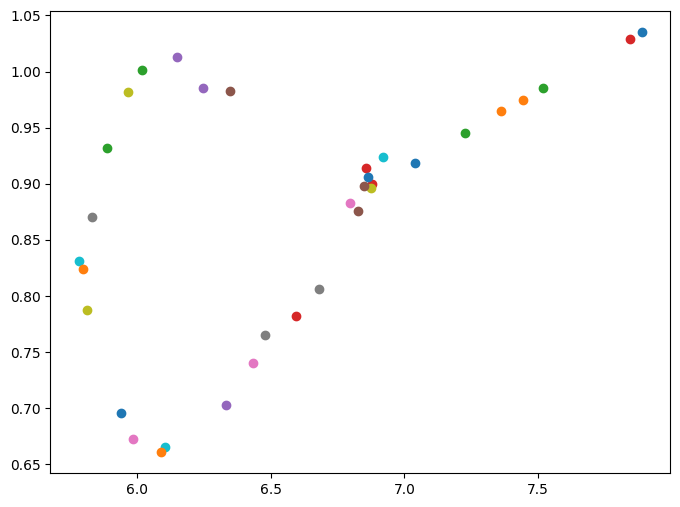

In [45]:
# Compare with DeepWalk
print("Training DeepWalk...")
walks_str = [[str(node) for node in walk] for walk in walks]
deepwalk_model = Word2Vec(sentences=walks_str, vector_size=embedding_dim, window=5, min_count=1, sg=1, workers=4)
deepwalk_embeddings = np.array([deepwalk_model.wv[str(node)] for node in nodes])
plot_embeddings(deepwalk_embeddings, graph)

Training Node2Vec...


Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 414.18it/s]


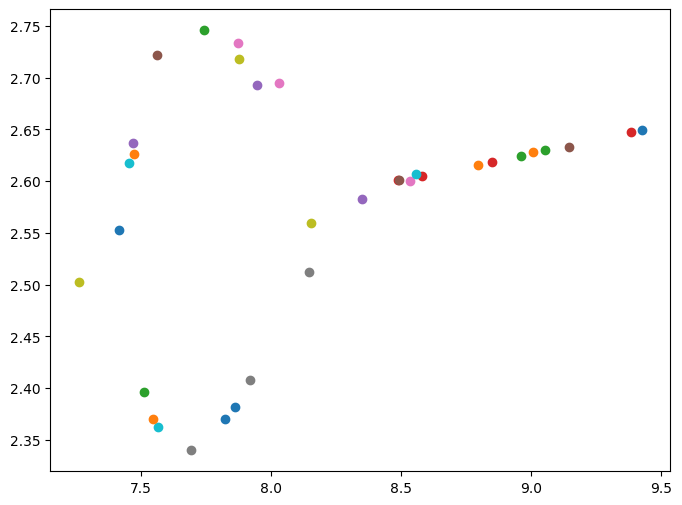

In [46]:
# Compare with Node2Vec
print("Training Node2Vec...")
node2vec = Node2Vec(graph, dimensions=embedding_dim, walk_length=walk_length, num_walks=num_walks, workers=4)
node2vec_model = node2vec.fit(window=5, min_count=1, sg=1)
node2vec_embeddings = np.array([node2vec_model.wv[str(node)] for node in nodes])
plot_embeddings(node2vec_embeddings, graph)